In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

In [ ]:
# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_SPLITS = 5
N_JOBS = -1
N_ESTIMATORS = 1000

In [31]:
df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data_final.csv').dropna()
df.head(2)

,# FP1-F7_mean,C3-P3_mean,C4-P4_mean,CZ-PZ_mean,F3-C3_mean,F4-C4_mean,F7-T7_mean,F8-T8_mean,FP1-F3_mean,FP2-F4_mean,...,P3-O1_line_length,P4-O2_line_length,P7-O1_line_length,P7-T7_line_length,P8-O2_line_length,T7-FT9_line_length,T7-P7_line_length,T8-P8-0_line_length,T8-P8-1_line_length,target
0,-0.000006,2.430477e-06,0.000007,2.915313e-07,0.000004,-0.000003,-1.960824e-06,0.000007,-0.000007,6.283437e-07,...,0.001057,0.001571,0.000693,0.000457,0.002003,0.001435,0.000457,0.000554,0.000554,0
1,-0.000004,6.301407e-07,0.000005,-1.961703e-06,-0.000002,-0.000005,7.762930e-07,0.000005,-0.000004,-8.191211e-06,...,0.001071,0.001638,0.000780,0.000531,0.002078,0.001436,0.000531,0.000588,0.000588,0


In [32]:
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print("Class distribution after shuffling:")
print(df['target'].value_counts(normalize=True))
df.head(2)

Class distribution after shuffling:
target
1    0.500061
0    0.499939
Name: proportion, dtype: float64


,# FP1-F7_mean,C3-P3_mean,C4-P4_mean,CZ-PZ_mean,F3-C3_mean,F4-C4_mean,F7-T7_mean,F8-T8_mean,FP1-F3_mean,FP2-F4_mean,...,P3-O1_line_length,P4-O2_line_length,P7-O1_line_length,P7-T7_line_length,P8-O2_line_length,T7-FT9_line_length,T7-P7_line_length,T8-P8-0_line_length,T8-P8-1_line_length,target
0,-0.000009,0.000002,-0.000006,0.000006,-0.000005,-0.000002,-0.000023,-2.917930e-07,-0.000030,-0.000016,...,0.001755,0.003191,0.005120,0.008812,0.006916,0.007487,0.008811,0.007215,0.007215,1
1,-0.000027,-0.000034,0.000002,-0.000007,-0.000008,0.000009,-0.000002,5.838319e-07,-0.000034,-0.000016,...,0.002725,0.003510,0.003098,0.008251,0.003259,0.009045,0.008251,0.004289,0.004289,0


In [33]:
# Split features and target
X = df.drop('target', axis=1)
y = df['target']
features = X.columns.tolist()

In [34]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

# Verify splits
print(f"\nTrain-val size: {len(X_trainval)}, Test size: {len(X_test)}")
print("Test set class distribution:", np.unique(y_test, return_counts=True))


Train-val size: 13105, Test size: 3277
Test set class distribution: (array([0, 1]), array([1638, 1639]))


In [35]:
cv_metrics = {
    'accuracy': [], 'precision': [], 'recall': [],
    'f1': [], 'roc_auc': []
}

# Storage for fold results
all_y_val = []
all_y_pred = []
all_y_proba = []
feature_importances = []

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [36]:
def process_fold(train_idx, val_idx):
    X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
    
    # Class weights
    weights = class_weight.compute_class_weight(
        'balanced', 
        classes=np.unique(y_train), 
        y=y_train
    )
    weight_dict = dict(zip(np.unique(y_train), weights))
    
    # Model training
    rf = RandomForestClassifier(
        n_estimators=N_ESTIMATORS,
        max_depth=15,
        class_weight=weight_dict,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_val)
    y_proba = rf.predict_proba(X_val)[:, 1]
    
    return {
        'y_val': y_val,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'importances': rf.feature_importances_
    }

# Parallel execution
results = Parallel(n_jobs=min(N_SPLITS, N_JOBS), verbose=10)(
    delayed(process_fold)(train_idx, val_idx)
    for train_idx, val_idx in skf.split(X_trainval, y_trainval)
)

# Aggregate results
for result in results:
    all_y_val.extend(result['y_val'])
    all_y_pred.extend(result['y_pred'])
    all_y_proba.extend(result['y_proba'])
    feature_importances.append(result['importances'])
    
    # Calculate metrics
    cv_metrics['accuracy'].append(accuracy_score(result['y_val'], result['y_pred']))
    cv_metrics['precision'].append(precision_score(result['y_val'], result['y_pred']))
    cv_metrics['recall'].append(recall_score(result['y_val'], result['y_pred']))
    cv_metrics['f1'].append(f1_score(result['y_val'], result['y_pred']))
    cv_metrics['roc_auc'].append(roc_auc_score(result['y_val'], result['y_proba']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.5min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished



Cross-Validation Metrics:
Accuracy: 0.9506 (±0.0046)
Precision: 0.9574 (±0.0032)
Recall: 0.9431 (±0.0076)
F1: 0.9502 (±0.0048)
ROC AUC: 0.9908 (±0.0015)


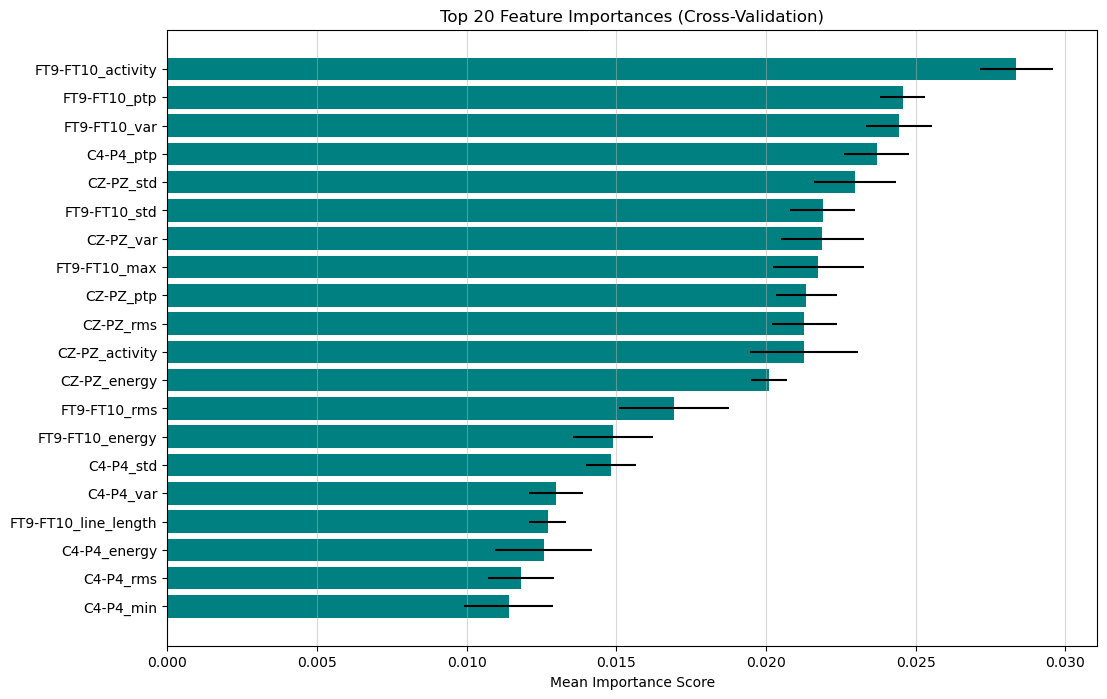

In [37]:
print("\nCross-Validation Metrics:")
print(f"Accuracy: {np.mean(cv_metrics['accuracy']):.4f} (±{np.std(cv_metrics['accuracy']):.4f})")
print(f"Precision: {np.mean(cv_metrics['precision']):.4f} (±{np.std(cv_metrics['precision']):.4f})")
print(f"Recall: {np.mean(cv_metrics['recall']):.4f} (±{np.std(cv_metrics['recall']):.4f})")
print(f"F1: {np.mean(cv_metrics['f1']):.4f} (±{np.std(cv_metrics['f1']):.4f})")
print(f"ROC AUC: {np.mean(cv_metrics['roc_auc']):.4f} (±{np.std(cv_metrics['roc_auc']):.4f})")

# Feature Importance Visualization
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)
indices = np.argsort(mean_importances)[-20:]

plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances (Cross-Validation)')
plt.barh(range(len(indices)), mean_importances[indices], xerr=std_importances[indices],
         align='center', color='teal', ecolor='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Mean Importance Score')
plt.grid(axis='x', alpha=0.5)
plt.show()


Test Set Evaluation:
              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96      1638
       Event       0.97      0.95      0.96      1639

    accuracy                           0.96      3277
   macro avg       0.96      0.96      0.96      3277
weighted avg       0.96      0.96      0.96      3277



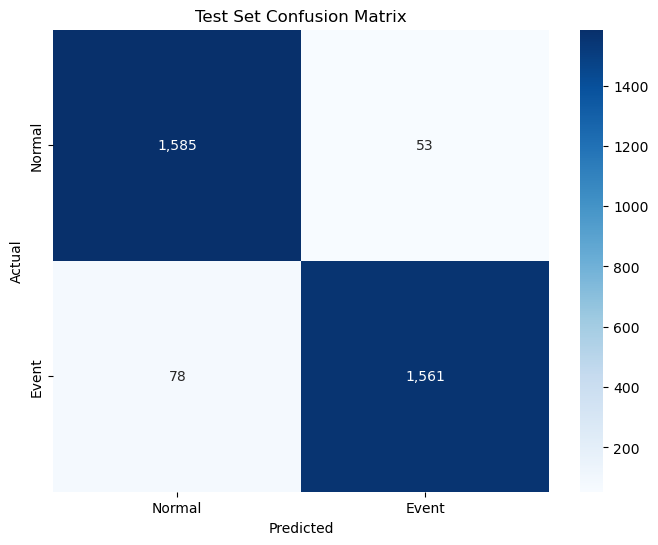

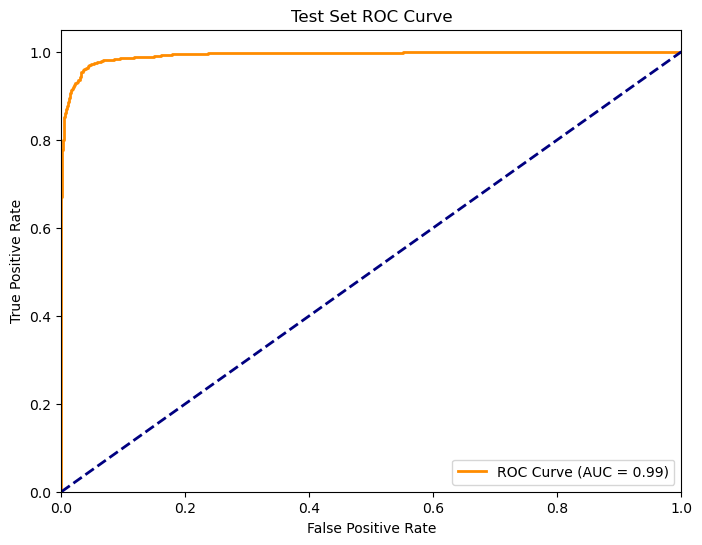

In [38]:
# Train final model on all train-val data
final_rf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=15,
    class_weight='balanced',
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE
)
final_rf.fit(X_trainval, y_trainval)

# Test set predictions
test_pred = final_rf.predict(X_test)
test_proba = final_rf.predict_proba(X_test)[:, 1]

# Final evaluation
print("\nTest Set Evaluation:")
print(classification_report(y_test, test_pred, target_names=['Normal', 'Event']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['Normal', 'Event'],
            yticklabels=['Normal', 'Event'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_score(y_test, test_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend(loc="lower right")
plt.show()